In [35]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from fancyimpute import KNN

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

train_path = "res/amazonReviews.800.train.csv"
test_path = "res/amazonReviews.700.test.csv"
result_folder = "results/"

test_set_ratio = 0.1 

In [2]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.head(10)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,545,5,4,3,2,2,3,1,1,2,...,0,0,0,0,0,0,0,1,0,Engineer
1,800,14,3,2,5,1,1,1,5,0,...,0,0,1,0,0,0,1,1,0,Kolln
2,1390,14,7,4,4,3,3,4,5,2,...,0,0,0,0,0,0,1,0,0,Vernon
3,1161,23,10,7,9,8,1,7,3,1,...,0,0,0,0,0,0,0,0,0,Nigam
4,23,13,3,3,6,1,5,0,3,3,...,0,0,0,0,1,0,0,1,0,Agresti
5,1386,11,16,7,9,9,6,0,2,2,...,0,0,0,0,0,0,1,0,0,Vernon
6,766,12,1,5,6,6,6,2,3,3,...,0,0,0,0,0,0,0,0,0,Koenig
7,1348,11,14,5,8,4,8,7,4,1,...,0,0,0,0,0,1,0,0,0,Sherwin
8,475,6,9,2,3,6,2,6,1,1,...,0,0,1,0,0,0,1,0,0,Cutey
9,132,1,2,6,0,0,0,8,1,2,...,0,0,0,0,0,0,0,0,0,Brody


### Initialize Training data

In [3]:
df_vars = df_train.loc[:, df_train.columns != 'Class']
df_class = df_train['Class']

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=test_set_ratio, random_state=0)
#clf = DecisionTreeClassifier(min_samples_split=7, random_state=13221323)
clf = MLPClassifier(random_state=123093234)

### Simple cross validation for well-founded results

In [4]:
scores = cross_validate(clf, df_vars, df_class, cv=5)
scores['test_score']

# dt criterion=gini
# array([0.93854749, 0.9408284 , 0.93125   , 0.90728477, 0.96453901])

E:\Python\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
E:\Python\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.48883990073937794

### Hyper-parameter tuning

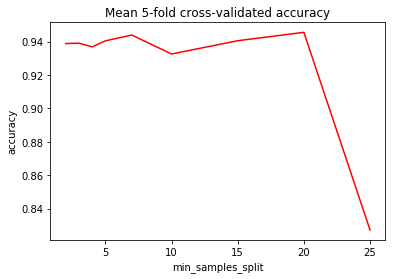

In [37]:
min_samples_splits = [2,3,4,5,7,10,15,20,25]
results = []
for min_samples_split in min_samples_splits:
    clf = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_validate(clf, df_vars, df_class, cv=5)
    results.append(scores['test_score'].mean())
    
plt.plot(min_samples_splits, results, "r", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("min_samples_split")
plt.title("Mean 5-fold cross-validated accuracy")
plt.show()

### Model fitting and sample testing

In [49]:
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

0.925

### Final prediction

In [50]:
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = pd.Series(model.predict(df_test))
df_res.head(10)

,ID,class
0,656,Harp
1,949,Mark
2,255,CFH
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


### Export

In [51]:
export_file_name = result_folder + "svm_linear.csv"
df_res.to_csv(export_file_name, index=False)

### Easy comparison

In [33]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid

df_vars = df_train.loc[:, df_train.columns != 'Class']
df_class = df_train['Class']

#df_vars = KNN(k=3).fit_transform(df_vars)

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]

classifiers = [
    NearestCentroid(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    GaussianNB()]

cl_scores = {}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars, df_class, cv=10, scoring='accuracy', return_train_score=True)
        cl_scores[name] = scores
        print(name,"-- Training Set --", "Mean", scores['train_score'].mean(), "-- Min", scores['train_score'].min(), "-- Max", scores['train_score'].max())
        print(name,"-- Test Set --", "Mean", scores['test_score'].mean(), "-- Min", scores['test_score'].min(), "-- Max", scores['test_score'].max())
    except:
        print("Classification failed for", name)
        traceback.print_exc()

Nearest Centroid -- Training Set -- Mean 0.7496791822186778 -- Min 0.7279005524861878 -- Max 0.7724039829302988
Nearest Centroid -- Test Set -- Mean 0.6628582456264915 -- Min 0.5873015873015873 -- Max 0.7543859649122807
Linear SVM -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Linear SVM -- Test Set -- Mean 0.9560670435070409 -- Min 0.9191919191919192 -- Max 1.0
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.9458952341983844 -- Min 0.9 -- Max 1.0
Naive Bayes -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Naive Bayes -- Test Set -- Mean 0.35593122949313594 -- Min 0.2727272727272727 -- Max 0.42857142857142855


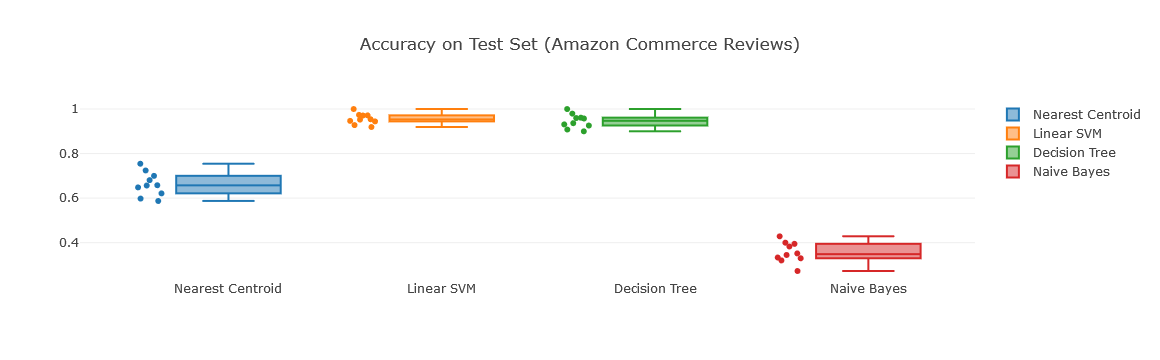

In [39]:
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_score'],
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="Accuracy on Test Set (Amazon Commerce Reviews)")
    
py.iplot(go.Figure(data=traces, layout=layout))